<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_2_Convolution_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Download Dataset

In [66]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/guava-disease-dataset


In [67]:
ds_folder = path+"/GuavaDiseaseDataset/GuavaDiseaseDataset/"

In [68]:
img_size = (224, 224)
img_channels = 3
batch_size = 64
lr = 1e-3

# Datasets and DataLoaders

In [69]:
train_dataset = ImageFolder(root=ds_folder + "train/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.RandomHorizontalFlip(0.5),
                                T.RandomVerticalFlip(0.5),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [70]:
test_dataset = ImageFolder(root=ds_folder + "test/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [71]:
val_dataset = ImageFolder(root=ds_folder + "val/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [72]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training Functins

In [73]:
def train_step(model, data_loader, criterion, optimizer, scheduler):

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Training")
  total_loss = 0.0
  total_correct = 0.0

  model.train()

  for image, label in progress_bar:
    images, labels = image.cuda(), label.cuda()

    optimizer.zero_grad()

    predictions = model(images)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_classes = torch.sum(predicted_classes == labels)
    loss = criterion(predictions, labels)

    total_correct += correct_classes.item()
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  scheduler.step(loss.item())

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [74]:
def evaluate(model, data_loader, criterion):

  model.eval()

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Evaluating")
  total_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    for image, label in progress_bar:
      images, labels = image.cuda(), label.cuda()

      predictions = model(images)
      predicted_classes = torch.argmax(predictions, dim=1)
      correct_classes = torch.sum(predicted_classes == labels)
      loss = criterion(predictions, labels)

      total_correct += correct_classes.item()
      total_loss += loss.item()

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [75]:
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs, experiment_name):

  df = pd.DataFrame(np.empty([epochs, 5]),
                    index=np.arange(epochs),
                    columns=["Train_Loss", "Train_Acc", "Val_Loss", "Val_Acc", "lr"])

  highest_acc = 0.00

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    df.iloc[epoch, 0], df.iloc[epoch, 1] = train_step(model=model, data_loader=train_dataloader,
                                            criterion=criterion, optimizer=optimizer,
                                            scheduler=scheduler)

    df.iloc[epoch, 2], df.iloc[epoch, 3] = evaluate(model=model, data_loader=val_dataloader,
                                            criterion=criterion)

    df.iloc[epoch, 4] = optimizer.param_groups[0]["lr"]

    print(f"Training Loss = {df.iloc[epoch, 0]:.7f}, Training Accuracy = {df.iloc[epoch, 1]:.3f}\nTesting Loss = {df.iloc[epoch, 2]:.7f}, Testing Accuracy = {df.iloc[epoch, 3]:.3f}")


    if df.iloc[epoch, 3] > highest_acc:
      torch.save(model.state_dict(), f"{experiment_name}.pth")
      highest_acc = df.iloc[epoch, 3]
      print(f"New best accuracy: {highest_acc:.3f} at epoch {epoch+1}")

    print("*"*50)
    print("")

  return df

# FC Neural Network

In [76]:
class FC_Model(nn.Module):
  def __init__(self, skeleton:list, num_classes):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.Dropout1d(0.5))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], num_classes))
    self.model = nn.Sequential(*layer_list)

  def forward(self, images):
    inputs = images.view(images.shape[0], -1)
    output = self.model(inputs)
    return output

In [77]:
model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 500, 300, 200, 100, 50, 20], num_classes=3).cuda()

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [79]:
fc_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="fully_connected")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0176378, Training Accuracy = 38.005
Testing Loss = 0.0171777, Testing Accuracy = 43.709
New best accuracy: 43.709 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Training Loss = 0.0174110, Training Accuracy = 36.947
Testing Loss = 0.0172692, Testing Accuracy = 36.026
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Training Loss = 0.0173451, Training Accuracy = 37.779
Testing Loss = 0.0172775, Testing Accuracy = 36.556
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Training Loss = 0.0174977, Training Accuracy = 35.852
Testing Loss = 0.0171825, Testing Accuracy = 49.934
New best accuracy: 49.934 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0171601, Training Accuracy = 38.761
Testing Loss = 0.0171770, Testing Accuracy = 41.060
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0171639, Training Accuracy = 37.816
Testing Loss = 0.0172030, Testing Accuracy = 49.404
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171799, Training Accuracy = 37.174
Testing Loss = 0.0171811, Testing Accuracy = 50.066
New best accuracy: 50.066 at epoch 7
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Training Loss = 0.0171089, Training Accuracy = 38.421
Testing Loss = 0.0171815, Testing Accuracy = 44.768
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0171524, Training Accuracy = 38.270
Testing Loss = 0.0171664, Testing Accuracy = 48.344
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Training Loss = 0.0171421, Training Accuracy = 36.910
Testing Loss = 0.0171900, Testing Accuracy = 48.609
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Training Loss = 0.0171788, Training Accuracy = 38.081
Testing Loss = 0.0171582, Testing Accuracy = 48.874
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0170892, Training Accuracy = 37.552
Testing Loss = 0.0171680, Testing Accuracy = 42.781
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Training Loss = 0.0170774, Training Accuracy = 37.665
Testing Loss = 0.0171681, Testing Accuracy = 41.987
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Training Loss = 0.0171281, Training Accuracy = 37.476
Testing Loss = 0.0171579, Testing Accuracy = 45.033
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0171161, Training Accuracy = 36.985
Testing Loss = 0.0171756, Testing Accuracy = 42.781
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170697, Training Accuracy = 39.063
Testing Loss = 0.0171898, Testing Accuracy = 41.722
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170565, Training Accuracy = 37.099
Testing Loss = 0.0171642, Testing Accuracy = 45.033
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171578, Training Accuracy = 37.250
Testing Loss = 0.0171970, Testing Accuracy = 41.060
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170989, Training Accuracy = 37.892
Testing Loss = 0.0171848, Testing Accuracy = 41.722
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170812, Training Accuracy = 36.607
Testing Loss = 0.0171448, Testing Accuracy = 42.252
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170848, Training Accuracy = 37.514
Testing Loss = 0.0171635, Testing Accuracy = 44.371
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171229, Training Accuracy = 36.872
Testing Loss = 0.0171627, Testing Accuracy = 41.987
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171002, Training Accuracy = 37.665
Testing Loss = 0.0171698, Testing Accuracy = 42.384
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0171062, Training Accuracy = 36.947
Testing Loss = 0.0171645, Testing Accuracy = 42.384
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0171075, Training Accuracy = 37.590
Testing Loss = 0.0171664, Testing Accuracy = 42.384
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Loss = 0.0170948, Training Accuracy = 38.572
Testing Loss = 0.0171657, Testing Accuracy = 43.311
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171199, Training Accuracy = 37.628
Testing Loss = 0.0171819, Testing Accuracy = 41.192
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171638, Training Accuracy = 36.343
Testing Loss = 0.0171437, Testing Accuracy = 42.517
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0171177, Training Accuracy = 38.836
Testing Loss = 0.0171464, Testing Accuracy = 44.238
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0171202, Training Accuracy = 38.119
Testing Loss = 0.0171554, Testing Accuracy = 42.252
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170994, Training Accuracy = 36.947
Testing Loss = 0.0171777, Testing Accuracy = 41.325
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170326, Training Accuracy = 38.534
Testing Loss = 0.0171522, Testing Accuracy = 45.695
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170975, Training Accuracy = 37.892
Testing Loss = 0.0171644, Testing Accuracy = 44.238
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170353, Training Accuracy = 39.252
Testing Loss = 0.0171560, Testing Accuracy = 42.781
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170323, Training Accuracy = 38.534
Testing Loss = 0.0171786, Testing Accuracy = 42.517
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0171902, Training Accuracy = 37.552
Testing Loss = 0.0171781, Testing Accuracy = 44.503
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170555, Training Accuracy = 36.607
Testing Loss = 0.0171628, Testing Accuracy = 45.298
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0170840, Training Accuracy = 36.494
Testing Loss = 0.0171759, Testing Accuracy = 43.576
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Training Loss = 0.0170458, Training Accuracy = 38.156
Testing Loss = 0.0171678, Testing Accuracy = 45.430
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0169907, Training Accuracy = 39.290
Testing Loss = 0.0171567, Testing Accuracy = 43.179
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0172018, Training Accuracy = 36.003
Testing Loss = 0.0171770, Testing Accuracy = 49.669
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Training Loss = 0.0170600, Training Accuracy = 37.287
Testing Loss = 0.0171679, Testing Accuracy = 43.444
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0170600, Training Accuracy = 38.270
Testing Loss = 0.0171685, Testing Accuracy = 41.325
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0170708, Training Accuracy = 38.988
Testing Loss = 0.0171700, Testing Accuracy = 41.325
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170203, Training Accuracy = 37.816
Testing Loss = 0.0171687, Testing Accuracy = 43.046
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170749, Training Accuracy = 38.459
Testing Loss = 0.0171512, Testing Accuracy = 42.517
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0171526, Training Accuracy = 36.079
Testing Loss = 0.0171647, Testing Accuracy = 42.384
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0171057, Training Accuracy = 38.874
Testing Loss = 0.0171744, Testing Accuracy = 44.636
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Training Loss = 0.0170971, Training Accuracy = 37.854
Testing Loss = 0.0171802, Testing Accuracy = 42.119
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]

Training Loss = 0.0171368, Training Accuracy = 37.363
Testing Loss = 0.0171713, Testing Accuracy = 42.781
**************************************************



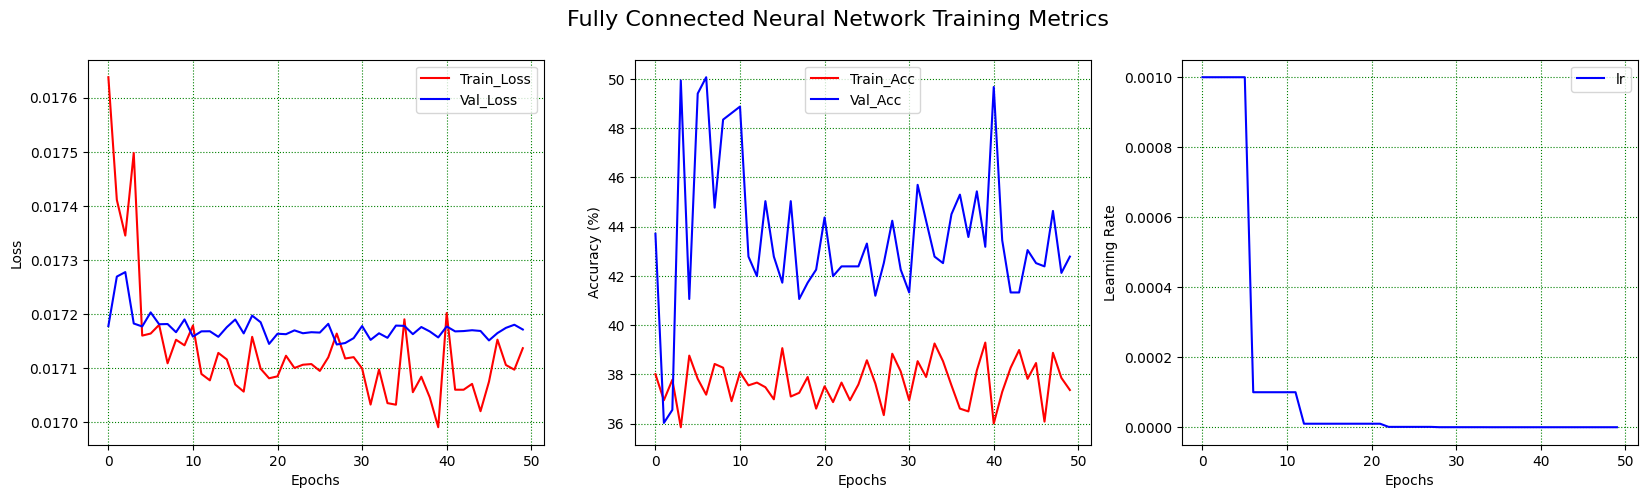

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

fc_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
fc_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
fc_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Fully Connected Neural Network Training Metrics', fontsize=16,)
plt.show()

# Custom CNN Layer - RESNet 9

In [81]:
def basic(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.Dropout2d(0.3),
      nn.ReLU(inplace=True),
  )

In [82]:
class RS_block(nn.Module):
  def __init__(self, in_channels, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, in_channels),
        basic(in_channels, in_channels),
        basic(in_channels, in_channels)
    )

  def forward(self, x):
    return x + self.net(x)

In [83]:
class ResNet9(nn.Module):

  def __init__(self, in_channels=img_channels, num_classes=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, 8),
        basic(8, 32), nn.MaxPool2d(2),
        RS_block(32),
        basic(32, 64),
        basic(64, 128), nn.MaxPool2d(2),
        RS_block(128),
        basic(128, 256), nn.MaxPool2d(2),
        basic(256, 512), nn.MaxPool2d(2),
        RS_block(512),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    output = self.net(x)
    return output

In [84]:
model = ResNet9().cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [85]:
my_cnn = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="my_cnn")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Loss = 0.9810897, Training Accuracy = 55.043
Testing Loss = 1.8893695, Testing Accuracy = 34.570
New best accuracy: 34.570 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.7607536, Training Accuracy = 65.848
Testing Loss = 1.2946160, Testing Accuracy = 43.709
New best accuracy: 43.709 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.7069622, Training Accuracy = 70.117
Testing Loss = 0.8042256, Testing Accuracy = 66.887
New best accuracy: 66.887 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.7081158, Training Accuracy = 70.079
Testing Loss = 0.8097919, Testing Accuracy = 63.444
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.6514536, Training Accuracy = 72.270
Testing Loss = 0.9686484, Testing Accuracy = 62.517
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Training Loss = 0.6470485, Training Accuracy = 73.139
Testing Loss = 0.7323115, Testing Accuracy = 65.033
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.6197931, Training Accuracy = 74.008
Testing Loss = 0.7365632, Testing Accuracy = 61.722
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.6232901, Training Accuracy = 74.424
Testing Loss = 0.7672484, Testing Accuracy = 66.225
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.6326545, Training Accuracy = 74.159
Testing Loss = 0.6385146, Testing Accuracy = 70.199
New best accuracy: 70.199 at epoch 9
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.5896946, Training Accuracy = 75.557
Testing Loss = 0.6116135, Testing Accuracy = 71.391
New best accuracy: 71.391 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.5750942, Training Accuracy = 75.859
Testing Loss = 0.5080990, Testing Accuracy = 75.762
New best accuracy: 75.762 at epoch 11
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.5475458, Training Accuracy = 77.144
Testing Loss = 0.5349236, Testing Accuracy = 73.377
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.5393520, Training Accuracy = 78.353
Testing Loss = 0.6855681, Testing Accuracy = 67.815
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.5062496, Training Accuracy = 79.675
Testing Loss = 0.6165075, Testing Accuracy = 72.185
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Loss = 0.4941876, Training Accuracy = 80.393
Testing Loss = 0.6294015, Testing Accuracy = 71.258
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4845577, Training Accuracy = 80.960
Testing Loss = 0.6066474, Testing Accuracy = 72.318
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4827048, Training Accuracy = 80.468
Testing Loss = 0.5822540, Testing Accuracy = 73.245
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4578220, Training Accuracy = 80.620
Testing Loss = 0.5805932, Testing Accuracy = 73.245
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4645492, Training Accuracy = 81.337
Testing Loss = 0.5561153, Testing Accuracy = 74.702
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Loss = 0.4789547, Training Accuracy = 81.677
Testing Loss = 0.5470336, Testing Accuracy = 74.570
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.4452805, Training Accuracy = 82.697
Testing Loss = 0.5361710, Testing Accuracy = 75.894
New best accuracy: 75.894 at epoch 21
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4424076, Training Accuracy = 83.302
Testing Loss = 0.5010635, Testing Accuracy = 76.689
New best accuracy: 76.689 at epoch 22
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4649086, Training Accuracy = 81.791
Testing Loss = 0.5208716, Testing Accuracy = 75.894
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4524534, Training Accuracy = 82.320
Testing Loss = 0.5447605, Testing Accuracy = 75.364
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4652920, Training Accuracy = 81.640
Testing Loss = 0.5319132, Testing Accuracy = 75.894
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Loss = 0.4546824, Training Accuracy = 82.357
Testing Loss = 0.5374121, Testing Accuracy = 75.629
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4366698, Training Accuracy = 83.717
Testing Loss = 0.5608192, Testing Accuracy = 75.099
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Training Loss = 0.4462253, Training Accuracy = 81.791
Testing Loss = 0.5118435, Testing Accuracy = 76.159
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4590482, Training Accuracy = 81.753
Testing Loss = 0.5376795, Testing Accuracy = 75.232
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4659742, Training Accuracy = 81.564
Testing Loss = 0.5117690, Testing Accuracy = 76.424
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4538465, Training Accuracy = 81.866
Testing Loss = 0.5736603, Testing Accuracy = 74.305
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Loss = 0.4412344, Training Accuracy = 83.151
Testing Loss = 0.5484254, Testing Accuracy = 75.099
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4650624, Training Accuracy = 81.035
Testing Loss = 0.5284858, Testing Accuracy = 75.629
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4689704, Training Accuracy = 82.131
Testing Loss = 0.5543526, Testing Accuracy = 74.702
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4498463, Training Accuracy = 81.715
Testing Loss = 0.5608988, Testing Accuracy = 74.834
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4713236, Training Accuracy = 82.622
Testing Loss = 0.5914244, Testing Accuracy = 74.305
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.4375707, Training Accuracy = 83.037
Testing Loss = 0.5343176, Testing Accuracy = 75.629
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4693495, Training Accuracy = 81.300
Testing Loss = 0.5297959, Testing Accuracy = 75.629
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4540461, Training Accuracy = 81.904
Testing Loss = 0.5162794, Testing Accuracy = 76.159
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4441212, Training Accuracy = 82.622
Testing Loss = 0.5428167, Testing Accuracy = 75.364
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4501447, Training Accuracy = 82.509
Testing Loss = 0.5232463, Testing Accuracy = 76.026
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Loss = 0.4475891, Training Accuracy = 82.546
Testing Loss = 0.4930778, Testing Accuracy = 77.219
New best accuracy: 77.219 at epoch 42
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4549450, Training Accuracy = 82.244
Testing Loss = 0.4999342, Testing Accuracy = 76.424
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4445699, Training Accuracy = 82.660
Testing Loss = 0.5632325, Testing Accuracy = 74.967
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4660990, Training Accuracy = 81.980
Testing Loss = 0.5664923, Testing Accuracy = 74.305
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4518027, Training Accuracy = 82.282
Testing Loss = 0.5388857, Testing Accuracy = 75.629
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Training Loss = 0.4714179, Training Accuracy = 81.866
Testing Loss = 0.5765138, Testing Accuracy = 73.642
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4438375, Training Accuracy = 82.509
Testing Loss = 0.5817936, Testing Accuracy = 74.040
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Training Loss = 0.4464220, Training Accuracy = 82.395
Testing Loss = 0.5373439, Testing Accuracy = 75.894
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

Training Loss = 0.4425154, Training Accuracy = 82.320
Testing Loss = 0.5272685, Testing Accuracy = 75.894
**************************************************



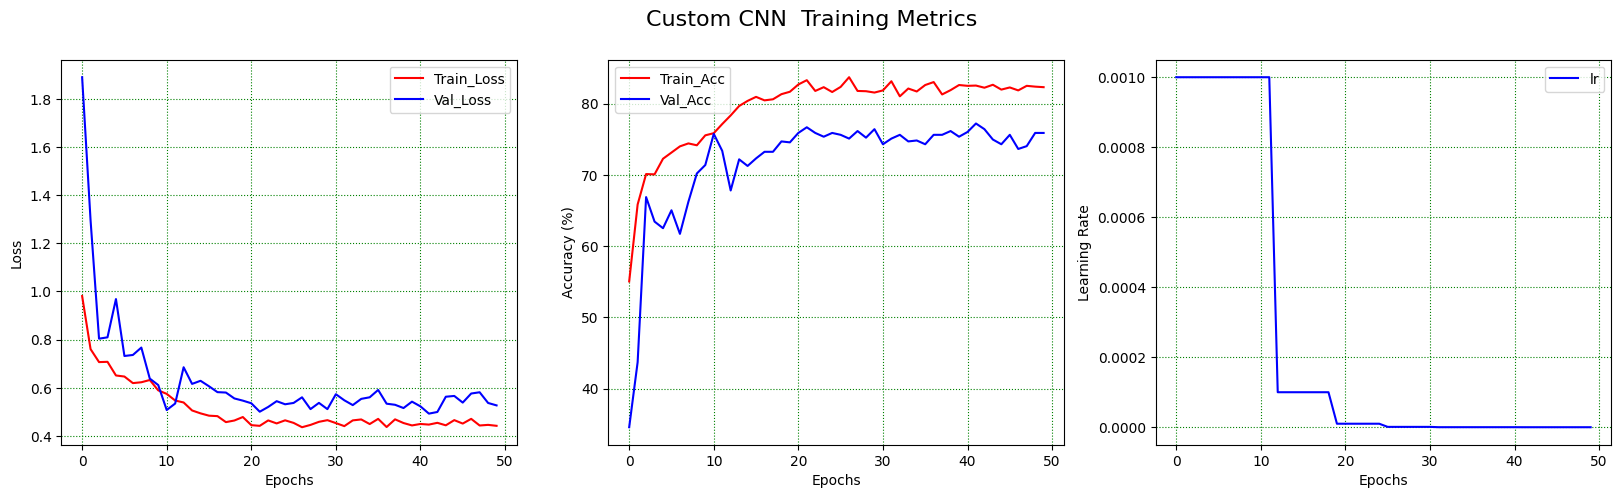

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

my_cnn.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
my_cnn.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
my_cnn.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Transfer Learning

In [87]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
model.eval()

for params in model.parameters():
  params.requires_grad = False

In [89]:
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

In [90]:
model = model.cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [ ]:
transfer_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=10, experiment_name="tranfer")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Training Loss = 0.5337260, Training Accuracy = 82.206
Testing Loss = 0.2217884, Testing Accuracy = 97.219
New best accuracy: 97.219 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Training Loss = 0.1865556, Training Accuracy = 96.487
Testing Loss = 0.1444169, Testing Accuracy = 96.556
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Training Loss = 0.1361905, Training Accuracy = 96.902
Testing Loss = 0.1069768, Testing Accuracy = 97.483
New best accuracy: 97.483 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Training Loss = 0.1063768, Training Accuracy = 97.318
Testing Loss = 0.0781104, Testing Accuracy = 98.808
New best accuracy: 98.808 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Training Loss = 0.0818416, Training Accuracy = 98.376
Testing Loss = 0.0643300, Testing Accuracy = 99.338
New best accuracy: 99.338 at epoch 5
**************************************************

Epoch 6


Training:  10%|▉         | 4/42 [00:05<00:47,  1.24s/it]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

transfer_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
transfer_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
transfer_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()